## Overview
In the experimental, I explore how to use model to detect disaster tweets.

## Setup
First of all, let me import necessary libraries.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_addons as tfa
import keras_tuner as kt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

## EDA
View head rows with pandas. There are five columns: id, keyword, location, text and target. I will use text as the model input and use target as true label, the model predicts results from text content. 

In [3]:
df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


The dataset contains two label values 0 and 1.

In [4]:
df['target'].unique()

array([1, 0])

There are urls, line breaks and extra spaces in the text, I use following method to format the text.

In [5]:
def clean_text(text):
    text = re.sub(r'https?://\S+', '', text) # Remove link
    text = re.sub(r'\n',' ', text) # Remove line breaks
    text = re.sub('\s+', ' ', text).strip() # Remove leading, trailing, and extra spaces
    text = re.sub('#', '', text)
    text = re.sub('@', '', text)
    return text

Store the cleaned text in ```text_clean``` column and separate the dataset to train(80%) and test(20%) csv files.

In [6]:
train_df, val_df = train_test_split(df, test_size=0.2)
train_df['text_clean'] = train_df['text'].apply(lambda x: clean_text(x))
val_df['text_clean'] = val_df['text'].apply(lambda x: clean_text(x))
train_df = train_df.drop(['keyword', 'location'], axis=1)
val_df = val_df.drop(['keyword', 'location'], axis=1)
train_df.to_csv('./train.csv', index=False)
val_df.to_csv('./val.csv', index=False)

There are 6090 entries in train dataset and 1523 entries in validate dataset.

In [7]:
train_df.info()
val_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6090 entries, 3223 to 5206
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          6090 non-null   int64 
 1   text        6090 non-null   object
 2   target      6090 non-null   int64 
 3   text_clean  6090 non-null   object
dtypes: int64(2), object(2)
memory usage: 237.9+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1523 entries, 7480 to 3180
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          1523 non-null   int64 
 1   text        1523 non-null   object
 2   target      1523 non-null   int64 
 3   text_clean  1523 non-null   object
dtypes: int64(2), object(2)
memory usage: 59.5+ KB


In order to optimize dataset performance, I read csv by tensorflow dataset apis. Here, I set batch size is 128 and use 32 threads to parallel read data from the csv files. 

In [8]:
train_dataset = tf.data.experimental.make_csv_dataset(
      './train.csv',
      batch_size=128,
      label_name='target',
      num_epochs=1,
      num_parallel_reads=32,
      shuffle=True,
      sloppy=True,
      ignore_errors=True)

val_dataset = tf.data.experimental.make_csv_dataset(
      './val.csv',
      batch_size=128,
      label_name='target',
      num_epochs=1,
      num_parallel_reads=32,
      shuffle=False,
      sloppy=True,
      ignore_errors=True)

Use ```text_clean``` column as model input.

In [9]:
train_dataset = train_dataset.map(lambda x, y: (x['text_clean'], y))
val_dataset = val_dataset.map(lambda x, y: (x['text_clean'], y))

## Model Arch

I tried two model archs in the experiment. In the first model, I trained a custom embedding and add LSTM as RNN module in order to extract context information from text column. I employ F1 Score as metric, Adam as optimizer and Focal binary crossentropy as loss in the training process.

In [10]:
VOCAB_SIZE = 5000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))
def build_model(optimizer, label_smoothing, activation, filters, encoder, dropout_rate):
    model = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim=64,
            mask_zero=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(label_smoothing=label_smoothing),
                  optimizer=optimizer,
                  metrics=[tfa.metrics.F1Score(1, threshold=0.5)])
    return model
        
model = build_model(tf.keras.optimizers.Adam(1e-4), 0, 'relu', 64, encoder, 0.)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 357,249
Trainable params: 357,249
Non-trainable params: 0
__________________________________________________

The model gets F1 score about 0.75.

Epoch 1/10
48/48 [==============================] - 8s 72ms/step - loss: 0.1722 - f1_score: 0.0629 - val_loss: 0.1700 - val_f1_score: 0.0000e+00
Epoch 2/10
48/48 [==============================] - 2s 47ms/step - loss: 0.1694 - f1_score: 0.0112 - val_loss: 0.1657 - val_f1_score: 0.0784
Epoch 3/10
48/48 [==============================] - 2s 47ms/step - loss: 0.1612 - f1_score: 0.3622 - val_loss: 0.1525 - val_f1_score: 0.5384
Epoch 4/10
48/48 [==============================] - 2s 48ms/step - loss: 0.1394 - f1_score: 0.7213 - val_loss: 0.1332 - val_f1_score: 0.7194
Epoch 5/10
48/48 [==============================] - 2s 46ms/step - loss: 0.1164 - f1_score: 0.7917 - val_loss: 0.1201 - val_f1_score: 0.7378
Epoch 6/10
48/48 [==============================] - 2s 46ms/step - loss: 0.1011 - f1_score: 0.8224 - val_loss: 0.1164 - val_f1_score: 0.7546
Epoch 7/10
48/48 [==============================] - 2s 44ms/step - loss: 0.0905 - f1_score: 0.8418 - val_loss: 0.1152 - val_f1_score: 0.7572
Epoch 8/1

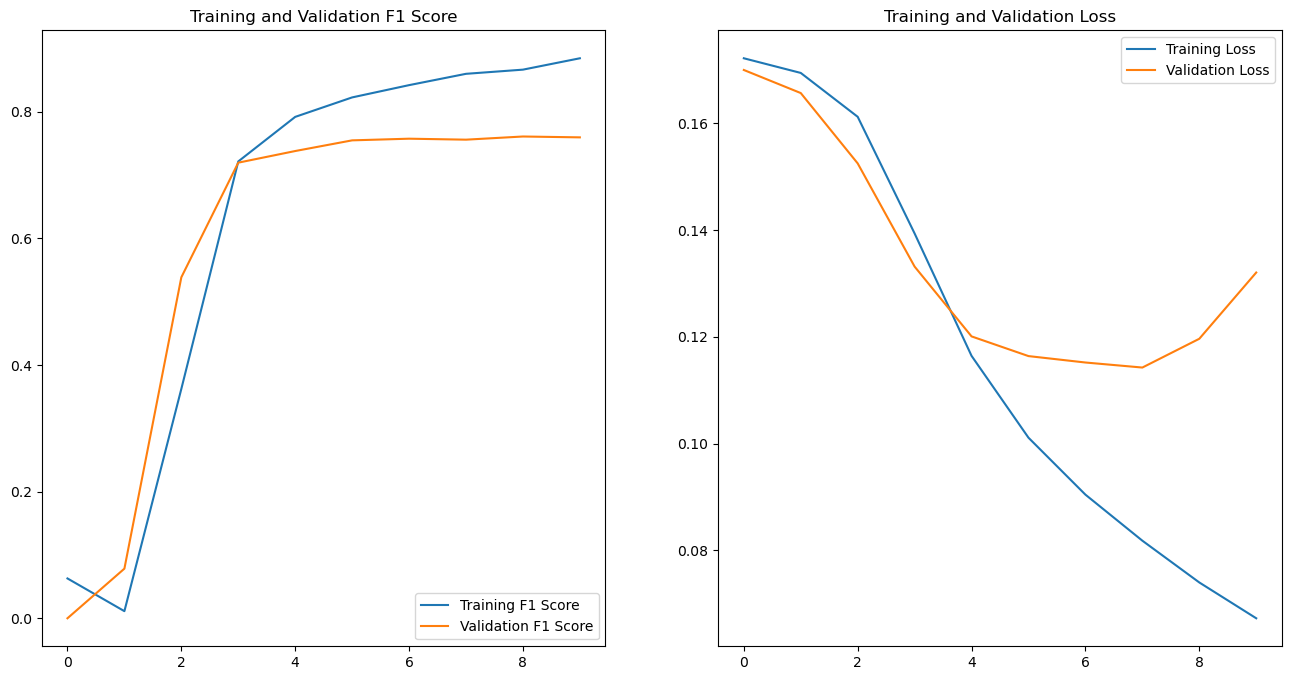

In [11]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)
f1_score = history.history['f1_score']
val_f1_score = history.history['val_f1_score']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, f1_score, label='Training F1 Score')
plt.plot(epochs_range, val_f1_score, label='Validation F1 Score')
plt.legend(loc='lower right')
plt.title('Training and Validation F1 Score')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In the second arch, I use Universal Sentence Encoder as encoder. It is trained on a variety of data sources and a variety of tasks with the aim of dynamically accommodating a wide variety of natural language understanding tasks. The input is variable length English text and the output is a 512 dimensional vector. The model works as follows:
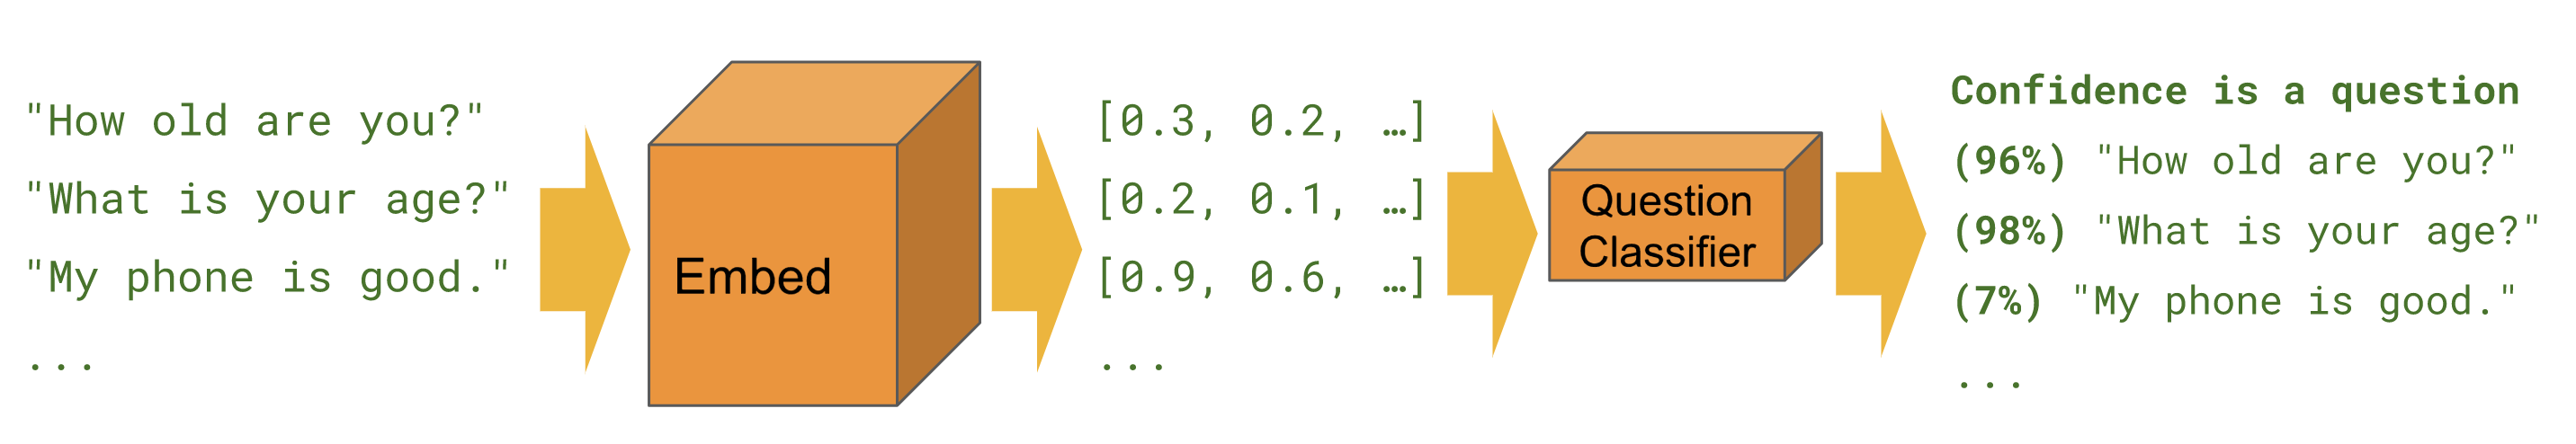
I employ F1 Score as metric, Adam as optimizer and Focal binary crossentropy as loss in the training process. In order to reduce model checkpoint size, I only save trainable variable and optimizer variables in the checkpoint.

In [12]:
def build_model(optimizer, label_smoothing, activation, filters, encoder, dropout_rate):
    inputs = tf.keras.Input(shape=[], dtype=tf.string)
    embedding = hub.KerasLayer(encoder)(inputs)
    dense1 = tf.keras.layers.Dense(filters, activation=activation)(embedding)
    dropout1 = tf.keras.layers.Dropout(dropout_rate)(dense1)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dropout1)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(label_smoothing=label_smoothing),
                  optimizer=optimizer,
                  metrics=[tfa.metrics.F1Score(1, threshold=0.5)])
    ckpt = tf.train.Checkpoint(optimizer=model.optimizer, trainable_weights=model.trainable_weights)
    model._checkpoint = ckpt
    return model
        
model = build_model('adam', 0, 'relu', 64, 'https://tfhub.dev/google/universal-sentence-encoder-large/5', 0.)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 keras_layer (KerasLayer)    (None, 512)               147354880 
                                                                 
 dense_2 (Dense)             (None, 64)                32832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 147,387,777
Trainable params: 32,897
Non-trainable params: 147,354,880
_________________________________________________________________


The model gets F1 score about 0.78.

Epoch 1/10
48/48 [==============================] - 68s 922ms/step - loss: 0.1401 - f1_score: 0.7072 - val_loss: 0.1101 - val_f1_score: 0.7826
Epoch 2/10
48/48 [==============================] - 41s 857ms/step - loss: 0.1099 - f1_score: 0.7801 - val_loss: 0.1032 - val_f1_score: 0.8000
Epoch 3/10
48/48 [==============================] - 41s 858ms/step - loss: 0.1031 - f1_score: 0.7919 - val_loss: 0.1001 - val_f1_score: 0.7983
Epoch 4/10
48/48 [==============================] - 43s 909ms/step - loss: 0.0989 - f1_score: 0.8024 - val_loss: 0.0997 - val_f1_score: 0.8007
Epoch 5/10
48/48 [==============================] - 44s 921ms/step - loss: 0.0960 - f1_score: 0.8050 - val_loss: 0.0993 - val_f1_score: 0.8003
Epoch 6/10
48/48 [==============================] - 43s 896ms/step - loss: 0.0935 - f1_score: 0.8094 - val_loss: 0.1008 - val_f1_score: 0.7931
Epoch 7/10
48/48 [==============================] - 42s 871ms/step - loss: 0.0917 - f1_score: 0.8140 - val_loss: 0.1005 - val_f1_score: 0.7910

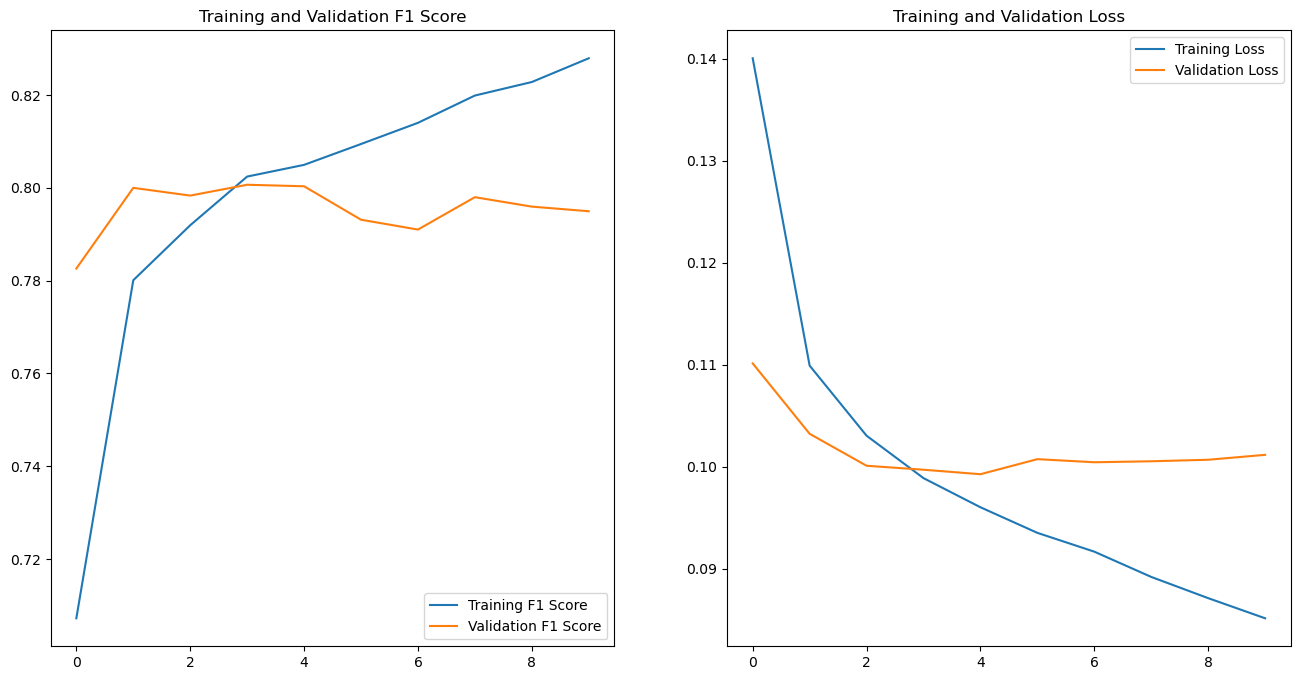

In [13]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)
f1_score = history.history['f1_score']
val_f1_score = history.history['val_f1_score']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, f1_score, label='Training F1 Score')
plt.plot(epochs_range, val_f1_score, label='Validation F1 Score')
plt.legend(loc='lower right')
plt.title('Training and Validation F1 Score')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Hyperparameter Tuning
With the help of Keras tuner, I set several candidates to the hyperparameter, I print search space via ```search_space_summary```. After tuning, I got a best model with score 0.79 on validate dataset.

In [14]:
def build_tuner(hp):
    optimizer = hp.Choice('optimizer', ['rmsprop', 'adam'])
    label_smoothing = hp.Choice('label_smothing', [0.0, 0.01])
    activation = hp.Choice('acitvation', ['relu', 'gelu'])
    filters = hp.Choice('filters', [32, 64, 128])
    encoder = hp.Choice('encoders', ["https://tfhub.dev/google/universal-sentence-encoder-large/5", "https://tfhub.dev/google/universal-sentence-encoder/4"])
    dropout_rate = hp.Choice('dropout_rate', [0., 0.25, 0.5])
    return build_model(optimizer, label_smoothing, activation, filters, encoder, dropout_rate)

tuner = kt.Hyperband(
    build_tuner,
    max_epochs=100,
    project_name='HistoPathologicCancerDetection',
    objective=kt.Objective("val_f1_score", direction="max"))
tuner.search_space_summary(extended=False)
tuner.search(train_dataset, validation_data=val_dataset, epochs=30)

Search space summary
Default search space size: 6
optimizer (Choice)
{'default': 'rmsprop', 'conditions': [], 'values': ['rmsprop', 'adam'], 'ordered': False}
label_smothing (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.01], 'ordered': True}
acitvation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'gelu'], 'ordered': False}
filters (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
encoders (Choice)
{'default': 'https://tfhub.dev/google/universal-sentence-encoder-large/5', 'conditions': [], 'values': ['https://tfhub.dev/google/universal-sentence-encoder-large/5', 'https://tfhub.dev/google/universal-sentence-encoder/4'], 'ordered': False}
dropout_rate (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.25, 0.5], 'ordered': True}


Let's draw the confusion matrix on top three models' predict results on validate dataset.

In [15]:
tuner.results_summary(3)
models = tuner.get_best_models(3)
cms = []
for model in models:
    targets = []
    preds = []
    for text, target in val_dataset:
        targets.append(target)
        preds.append(tf.cast(model(text)>0.5, tf.int32))
    targets = tf.concat(targets, axis=0)
    preds = tf.concat(preds, axis=0)
    cm = tf.math.confusion_matrix(targets, preds, num_classes=2)
    cms.append(cm)

Results summary
Results in ./HistoPathologicCancerDetection
Showing 3 best trials
Objective(name="val_f1_score", direction="max")

Trial 0146 summary
Hyperparameters:
optimizer: adam
label_smothing: 0.01
acitvation: relu
filters: 128
encoders: https://tfhub.dev/google/universal-sentence-encoder-large/5
dropout_rate: 0.25
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0144
Score: 0.7906250357627869

Trial 0144 summary
Hyperparameters:
optimizer: adam
label_smothing: 0.01
acitvation: relu
filters: 128
encoders: https://tfhub.dev/google/universal-sentence-encoder-large/5
dropout_rate: 0.25
tuner/epochs: 34
tuner/initial_epoch: 12
tuner/bracket: 4
tuner/round: 3
tuner/trial_id: 0141
Score: 0.790297269821167

Trial 0138 summary
Hyperparameters:
optimizer: adam
label_smothing: 0.01
acitvation: relu
filters: 128
encoders: https://tfhub.dev/google/universal-sentence-encoder-large/5
dropout_rate: 0.0
tuner/epochs: 12
tuner/initial_epoch: 4
tuner/bracke

<Axes: >

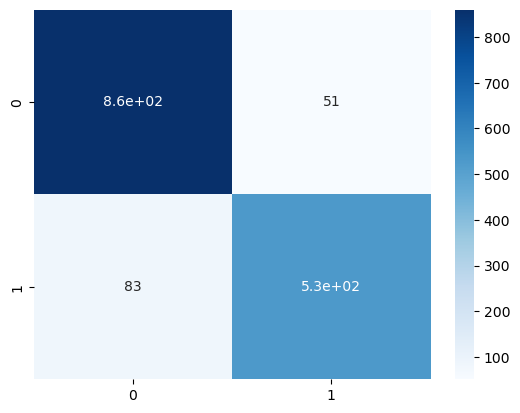

In [16]:
sns.heatmap(cms[0].numpy(), cmap="Blues", annot=True)

<Axes: >

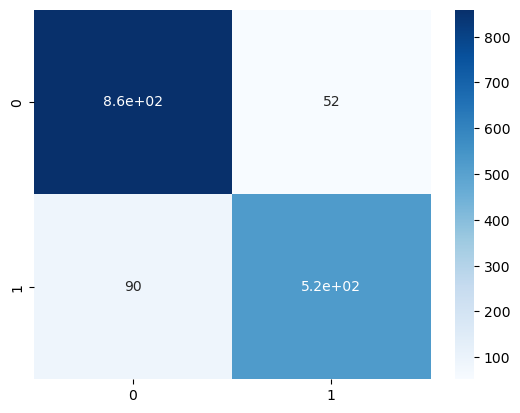

In [17]:
sns.heatmap(cms[1].numpy(), cmap="Blues", annot=True)

<Axes: >

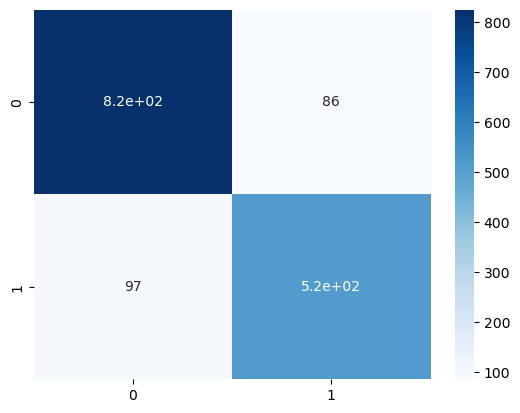

In [18]:
sns.heatmap(cms[2].numpy(), cmap="Blues", annot=True)

## Submit Results
Finally, I selected three best models from Keras tuner and submited their predict results on test dataset to Kaggle. I got a score about 0.81.

In [17]:
models = tuner.get_best_models(3)

test_dataset = tf.data.experimental.make_csv_dataset(
      '/kaggle/input/nlp-getting-started/test.csv',
      batch_size=128,
      select_columns=['id', 'text'],
      num_epochs=1,
      num_parallel_reads=32,
      shuffle=False,
      sloppy=True,
      ignore_errors=True)

for i, model in enumerate(models):
    id = []
    label = []
    for rows in test_dataset:
        probs = model.predict(rows['text'])
        id += rows['id'].numpy().tolist()
        label += (probs>0.5)[:, 0].astype(np.int32).tolist()
    data = {'id': id,
            'target': label}
    test_df = pd.DataFrame(data)
    test_df.to_csv(f'./submission_{i}.csv', index=False)

2/2 [==============================] - 6s 40ms/step


## Conclusion
According to the results, there is a gap between the model performance and SOTA performance. There are some aspects that may improve the model performance.

1. Data Augumentation. Since the dataset is small, I should use some methods to produce more data, such as translation augument, translate the sentence to another language then translate it to the original language could produce a new sentence.
2. Tune threshold. Here I set 0.5 as a constant threshold, maybe it's not the best value in this model, so I could tune it and get best one.

The tuner results also show the bigger encoder is always better than smaller one. Adam optimzier is better than rmsprop optimizer. Label smothing works on the model and maybe filters could be larger than current one. I will further explore these hyperparameters.